In [3]:
!pip install jovian --upgrade --quiet

In [4]:
project_name='06b-anime-dcgan'

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od
dataset_url='https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sagarpatel3199
Your Kaggle Key: ··········


  0%|          | 0.00/395M [00:00<?, ?B/s]

100%|██████████| 395M/395M [00:03<00:00, 109MB/s] 


In [7]:
import os

DATA_DIR='./animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [8]:
print(os.listdir(DATA_DIR+'/images')[:10])

['30879_2010.jpg', '9060_2004.jpg', '18509_2007.jpg', '50393_2015.jpg', '35581_2011.jpg', '15755_2006.jpg', '50259_2015.jpg', '30402_2010.jpg', '54847_2016.jpg', '17906_2007.jpg']


In [9]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [10]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [11]:
train_ds=ImageFolder(DATA_DIR,transform=T.Compose([
                                                   T.Resize(image_size),
                                                   T.CenterCrop(image_size),
                                                   T.ToTensor(),
                                                   T.Normalize(*stats)
]))
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [12]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [14]:
def show_images(images,nmax=64):
  fig,ax=plt.subplots(figsize=(8,8))
  ax.set_xticks([]);ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
  for images,_ in dl:
    show_images(images,nmax)
    break

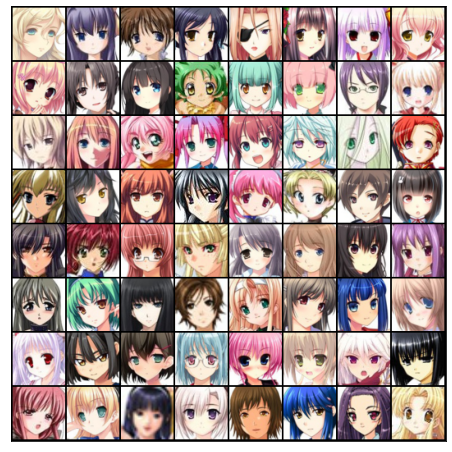

In [15]:
show_batch(train_dl)

In [16]:
!pip install jovian --upgrade --quiet

In [17]:
import jovian

In [18]:
jovian.commit(project=project_name,environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/sagarp3199/06b-anime-dcgan


'https://jovian.ai/sagarp3199/06b-anime-dcgan'

In [19]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  
  def __len__(self):
    return len(self.dl)

In [20]:
device =get_default_device()
device

device(type='cuda')

In [21]:
train_dl=DeviceDataLoader(train_dl,device)

In [22]:
import torch.nn as nn

In [23]:
discriminator=nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [24]:
discriminator=to_device(discriminator,device)

In [25]:
latent_size=128

In [26]:
generator=nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()   
)

torch.Size([128, 3, 64, 64])


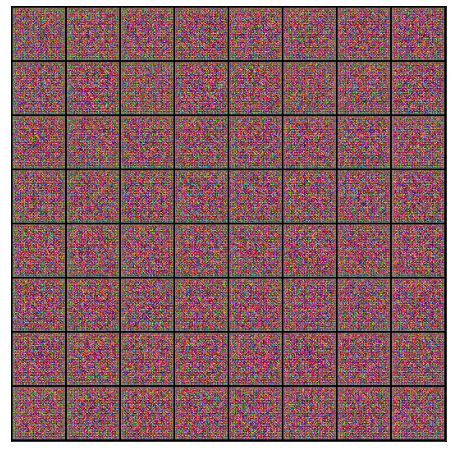

In [27]:
xb=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [28]:
generator=to_device(generator,device)

In [29]:
def train_discriminator(real_images,opt_d):
  opt_d.zero_grad()

  real_preds=discriminator(real_images)
  real_targets=torch.ones(real_images.size(0),1,device=device)
  real_loss=F.binary_cross_entropy(real_preds,real_targets)
  real_score=torch.mean(real_preds).item()

  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  fake_targets=torch.zeros(fake_images.size(0),1,device=device)
  fake_preds=discriminator(fake_images)
  fake_loss=F.binary_cross_entropy(fake_preds,fake_targets)
  fake_score=torch.mean(fake_preds).item()

  loss=real_loss+fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(),real_score,fake_score

In [30]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  preds=discriminator(fake_images)
  targets=torch.ones(batch_size,1,device=device)
  loss=F.binary_cross_entropy(preds,targets)

  loss.backward()
  opt_g.step()

  return loss.item()

In [31]:
from torchvision.utils import save_image

In [33]:
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [37]:
def save_samples(index,latent_tensors,show=True):
  fake_images=generator(latent_tensors)
  fake_fname='generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  print('Saving',fake_fname)
  if show:
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [38]:
fixed_latent=torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


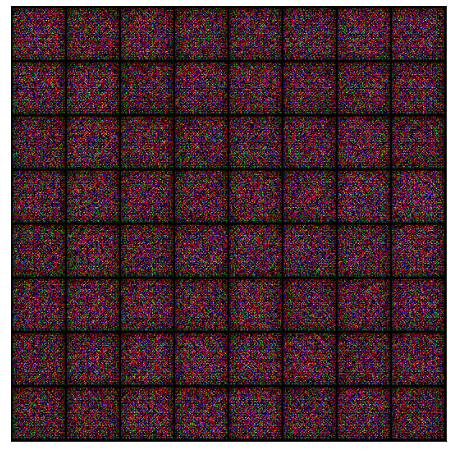

In [39]:
save_samples(0,fixed_latent)

In [40]:
jovian.commit(project=project_name,environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/sagarp3199/06b-anime-dcgan


'https://jovian.ai/sagarp3199/06b-anime-dcgan'

In [41]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [43]:
def fit(epochs,lr,start_idx=1):
  torch.cuda.empty_cache()

  losses_g=[]
  losses_d=[]
  real_scores=[]
  fake_scores=[]

  opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
  opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))
  for epoch in range(epochs):
    for real_images,_ in tqdm(train_dl):
      loss_d,real_score,fake_score=train_discriminator(real_images,opt_d)
      loss_g=train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
      epoch+1,epochs,loss_g,loss_d,real_score,fake_score
    ))
    save_samples(epoch+start_idx,fixed_latent,show=False)
  
  return losses_g,losses_d,real_scores,fake_scores  

In [44]:
lr=0.0002
epochs=10

In [46]:
jovian.reset()
jovian.log_hyperparams(lr=lr,epochs=epochs)

[jovian] Hyperparams logged.


In [47]:
history=fit(epochs,lr)


Epoch [1/10], loss_g: 3.6939, loss_d: 0.2836, real_score: 0.8710, fake_score: 0.1166
Saving generated-images-0001.png



Epoch [2/10], loss_g: 4.9738, loss_d: 0.4068, real_score: 0.8271, fake_score: 0.1557
Saving generated-images-0002.png



Epoch [3/10], loss_g: 3.5390, loss_d: 0.3939, real_score: 0.7728, fake_score: 0.0859
Saving generated-images-0003.png



Epoch [4/10], loss_g: 2.7403, loss_d: 0.3410, real_score: 0.7697, fake_score: 0.0285
Saving generated-images-0004.png



Epoch [5/10], loss_g: 3.7943, loss_d: 0.3167, real_score: 0.7895, fake_score: 0.0212
Saving generated-images-0005.png



Epoch [6/10], loss_g: 4.3385, loss_d: 0.1085, real_score: 0.9549, fake_score: 0.0564
Saving generated-images-0006.png



Epoch [7/10], loss_g: 4.6148, loss_d: 0.3774, real_score: 0.8793, fake_score: 0.1909
Saving generated-images-0007.png



Epoch [8/10], loss_g: 1.6776, loss_d: 3.0280, real_score: 0.1028, fake_score: 0.0003
Saving generated-images-0008.png



Epoch [9/10], loss_g: 3.2990, loss_d: 0.2724, real_score: 0.8442, fake_score: 0.0772
Saving generated-images-0009.png



Epoch [10/10], loss_g: 3.1221, loss_d: 0.1797, real_score: 0.9765, fake_score: 0.1312
Saving generated-images-0010.png


In [48]:
losses_g,losses_d,real_scores,fake_scores=history

In [49]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [50]:
torch.save(generator.state_dict(),'G.pth')

In [51]:
torch.save(discriminator.state_dict(),'D.pth')

In [52]:
from IPython.display import Image

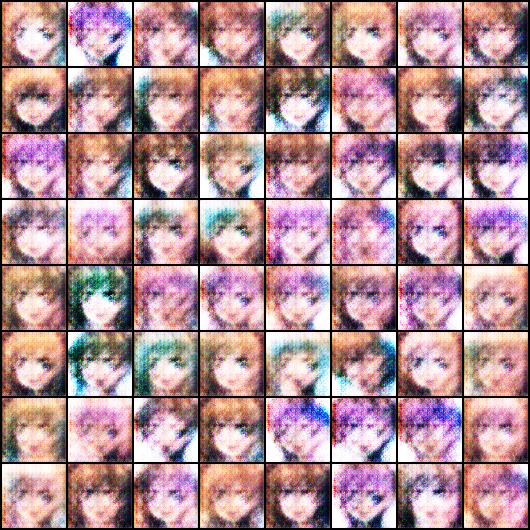

In [53]:
Image('./generated/generated-images-0001.png')

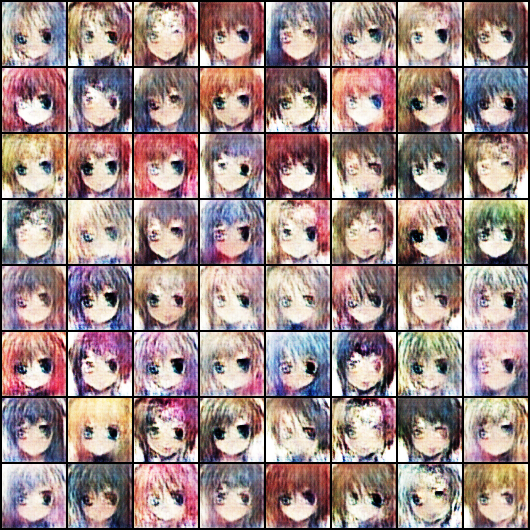

In [54]:
Image('./generated/generated-images-0003.png')

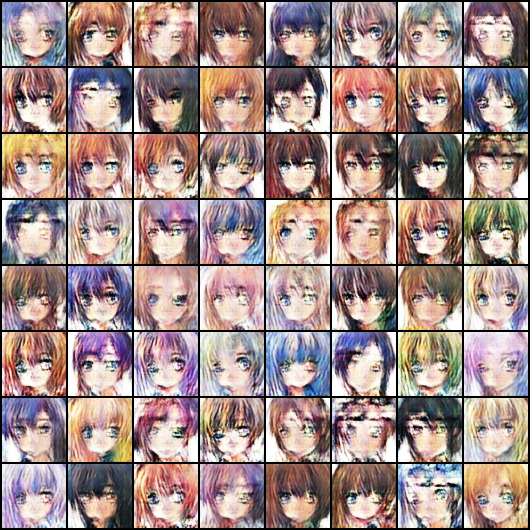

In [55]:
Image('./generated/generated-images-0005.png')

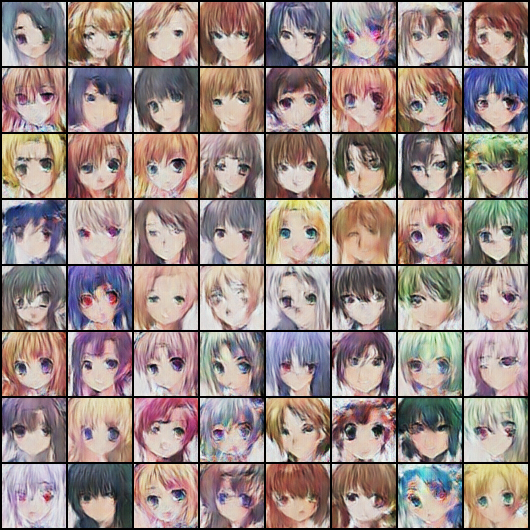

In [56]:
Image('./generated/generated-images-0010.png')

In [57]:
import cv2
import os

vid_fname='gans_training.avi'

In [58]:
files=[os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out=cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d,'-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()